In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


## EDA

In [2]:
# Reading in the data, seeing what values look like
data = pd.read_csv("insurance[1].csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Exploring variable types
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


Age, children, BMI, and charges are numeric while sex, smoker, and region are objects. We will encode our object type variables.

In [4]:
# Checking for NA vals
print(data.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


There are no missing values so we can proceed

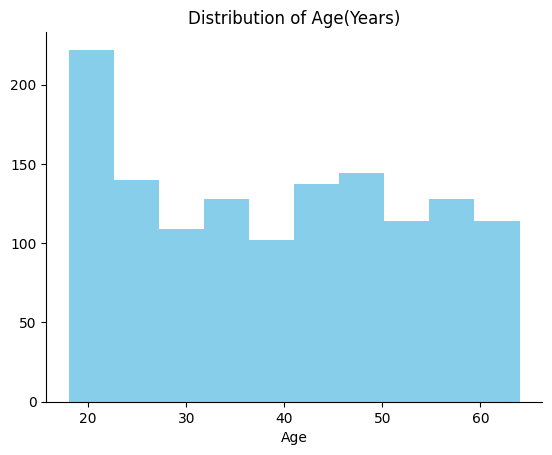

In [5]:
# Making histogram for distribution of age
plt.hist(data['age'], color = 'skyblue', bins = 10)
plt.xlabel('Age')
plt.title('Distribution of Age(Years)')
# Removing spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

The distribution of age is pretty even. There is a spike in our graph around 20, indicating younger ages might be more represented.

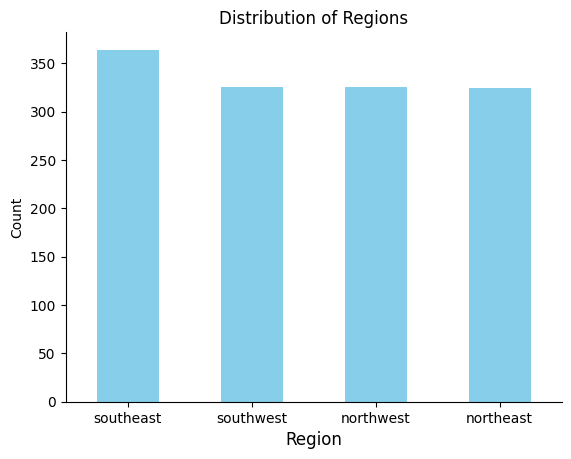

In [6]:
# Bar graph to show distribution of region
data['region'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Region', rotation=0, size=12)
# No rotation for better readability
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Regions')
# Removing spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Region is relatively evenly distributed

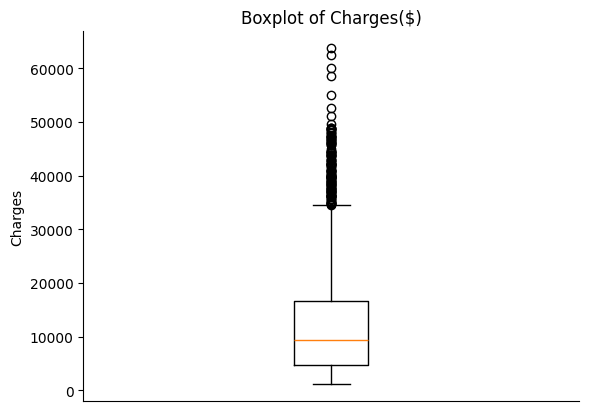

In [7]:
# Boxplot of charges, our target(also shows heavy skew)
plt.boxplot(data['charges'])
plt.xticks([])
plt.ylabel('Charges')
plt.title('Boxplot of Charges($)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [8]:
# Summary statistic of our response variable
charges_summary = data['charges'].describe().to_frame().reset_index()
charges_summary.columns = ['Statistic', 'Value']
charges_summary['Value'] = charges_summary['Value'].round(2)
charges_summary

,Statistic,Value
0,count,1338.00
1,mean,13270.42
2,std,12110.01
3,min,1121.87
4,25%,4740.29
5,50%,9382.03
6,75%,16639.91
7,max,63770.43


In [9]:
# Encoding smoker, sex, and region

# Using ordinal encoder for meaningful order of smoker vs. non-smoker
data[["smoker"]] = OrdinalEncoder().fit_transform(data[["smoker"]])
print(data["smoker"].value_counts())

# Using label encoder, no apparent meaningful difference
data["sex"] = LabelEncoder().fit_transform(data["sex"])
print(data["sex"].value_counts())

data["region"] = LabelEncoder().fit_transform(data["region"])
print(data["region"].value_counts())

smoker
0.0    1064
1.0     274
Name: count, dtype: int64
sex
1    676
0    662
Name: count, dtype: int64
region
2    364
3    325
1    325
0    324
Name: count, dtype: int64


In [10]:
# Percentiles for response varaible to determine bins
percentiles = np.percentile(data['charges'], [20, 40, 60, 80])
print(percentiles)

[ 3991.57572   7369.05273  11399.85716  20260.626406]


In [11]:
# Manually encoding response variable, creating a new one
data['charge_class'] = data['charges'].apply(lambda x: 0 if x < 3991.5757 else 1 if x < 7369.05 else 2 if x < 11399.85716 else 3 if x < 20260.626406 else 4)

In [12]:
print(data['charge_class'].value_counts())

charge_class
0    268
4    268
2    268
3    267
1    267
Name: count, dtype: int64


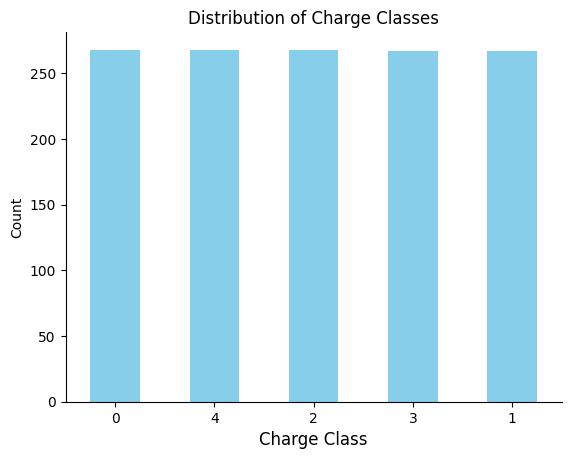

In [13]:
# Bar graph to show distribution of region
data['charge_class'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Charge Class', rotation=0, size=12)
# No rotation for better readability
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Charge Classes')
# Removing spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

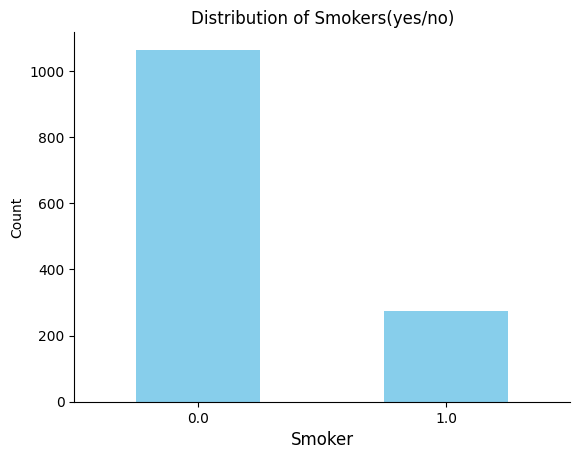

In [14]:
# Bar graph to show distribution of region
data['smoker'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Smoker', rotation=0, size=12)
# No rotation for better readability
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Smokers(yes/no)')
# Removing spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [15]:
# Train/tune/test split(stratifying by our response variable)
X = data.drop(columns=['charges', 'charge_class'])
y = data['charge_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=72)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50, random_state=72)

# Creating kfold object for validation
kf = RepeatedKFold(n_splits=10, n_repeats =5, random_state=10)

# Using f1 score(unbalanced dataset) and accuracy
scoring = ['f1_macro','accuracy']

#Starting with just one parameter of max depth
param = {"max_depth" : [1,2,3,4,5]}

cl= DecisionTreeClassifier(random_state=72)

#Gridsearch to find best max depth
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=-1, cv=kf,refit='f1_macro')

model = search.fit(X_train, y_train)
best = model.best_estimator_
print(best)

DecisionTreeClassifier(max_depth=5, random_state=72)


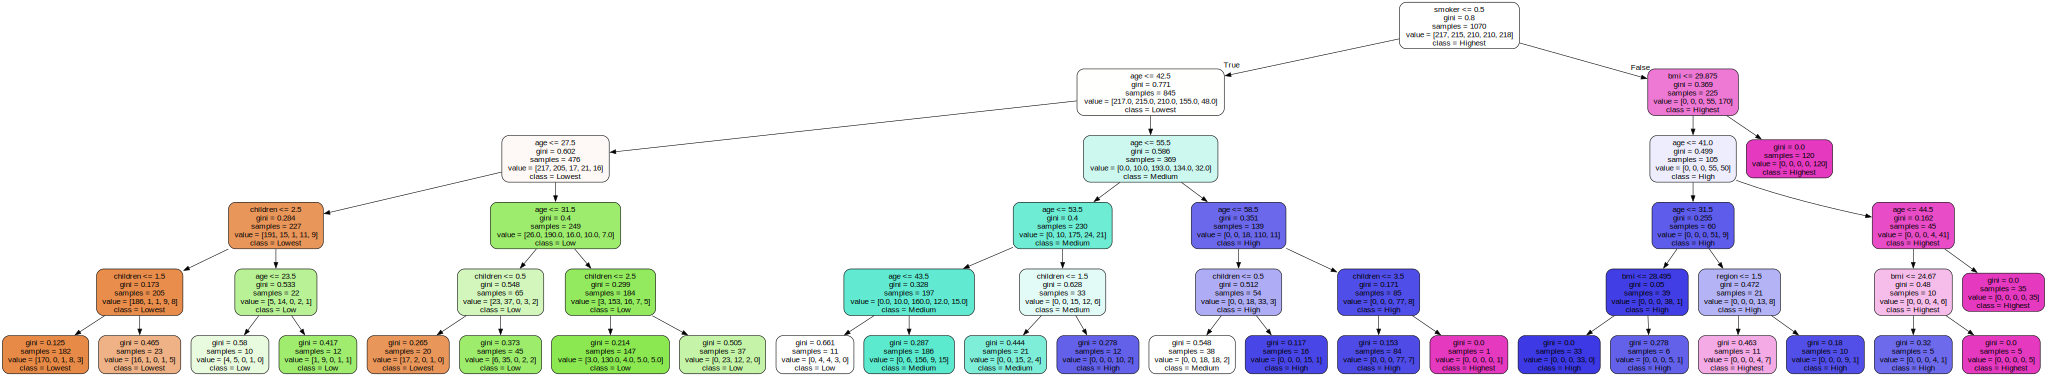

In [16]:
# Visualization of decision tree
dot_data = export_graphviz(best, out_file=None,
               feature_names=X.columns, # feature names from dataset
               filled=True, 
               rounded=True, 
               class_names=['Lowest', 'Low', 'Medium', 'High', 'Highest']) # classification labels 
graph_1 = graphviz.Source(dot_data)
graph_1 = graphviz.Source(dot_data)
graph_1
#graph_1.view()

In [17]:
# Variable importance, rounding for readability
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
varimp['importance'] = varimp['importance'].round(2)
print(varimp)

          importance
age             0.66
smoker          0.20
children        0.08
bmi             0.06
region          0.00
sex             0.00


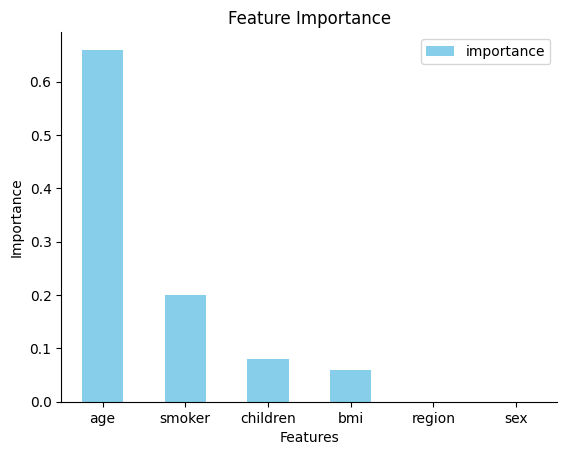

In [18]:
varimp.plot(kind='bar', color='skyblue')
plt.xlabel('Features')
plt.xticks(rotation=0, size=10)
plt.ylabel('Importance')
plt.title('Feature Importance')

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Our most important variable is age, followed by smoker. It seems that region and sex are not very important.

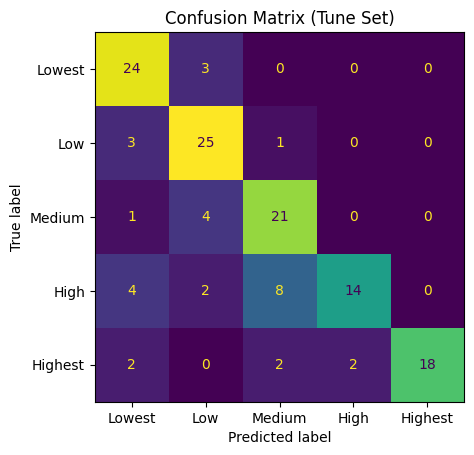

In [19]:
# Confusion matrix of our tune data
ConfusionMatrixDisplay.from_estimator(best, X_tune, y_tune, display_labels=['Lowest','Low','Medium','High','Highest'], colorbar=False)
plt.title('Confusion Matrix (Tune Set)')
plt.show()

Most of our missclassifcation comes from the high class. It predicts the label to be lowest, low, and medium at a relatively high rate. The accuracy for high is 50%. We believe we can improve this error by including more parameters.

In [20]:
# Predictions, classifcation report of important scores

y_pred_tune = best.predict(X_tune)
y_pred_test = best.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test, digits=4))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9583    0.9583    0.9583        24
           1     0.6875    0.9565    0.8000        23
           2     0.8065    0.7812    0.7937        32
           3     0.8571    0.8276    0.8421        29
           4     0.9474    0.6923    0.8000        26

    accuracy                         0.8358       134
   macro avg     0.8514    0.8432    0.8388       134
weighted avg     0.8515    0.8358    0.8360       134



- The precision measures what % is correct when predicting TP. This is pretty low for level 1(low) charges at 68.8%, and pretty high at the extremes with 95.8% for lowest and 94.7% for highest
- The recall measures what proportion of TP are being classified correctly. This is pretty low for our highest class, with 69.2%, but high for our lower classes with 95.8% for lowest and 95.7% for low. This indicates that our model better classifies true positives for low classes.
- The f1-score the harmonic mean of precision and recall, putting more weight on false negatives and positives. Our f1-score is pretty high for our lowest class at 95.8% but around 80% for our other classes. This indicates that our model performs well on the lowest class but could use improvement for other classes.
- Our accuracy shows the rate at which our model correctly classifies, correct classifications/total classifications. With a total accuracy of 83.6% our model is performing decently well but could be improved. 
- The macro average is the average of metrics in every class. The weighted average is similar to the macro average, but instead of treating every class equally, it weighs them based on number of samples per class.


Recreating tree based on Gridsearch of many parameters to see if this improves performance

In [21]:
# Train/tune/test split(stratify by response)
X = data.drop(columns=['charges', 'charge_class'])
y = data['charge_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=13)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50, random_state=72)

# Creating kfold object for validation
kf = RepeatedKFold(n_splits=10, n_repeats =5, random_state=10)

# Bringing in many parameters, didn't want to use a very wide range to lower train time
scoring = ['f1_macro','accuracy']
param_grid = {'max_depth': range(3, 8),
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 7],
    'criterion': ['gini', 'entropy']}
cl= DecisionTreeClassifier(random_state=1000)

# Gridsearch based on our parameters
search = GridSearchCV(cl, param_grid, scoring=scoring, n_jobs=-1, cv=kf,refit='f1_macro')

model = search.fit(X_train, y_train)
best = model.best_estimator_
print(best)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5,
                       min_samples_split=5, random_state=1000)


The best criterion was entropy, which is interesting. The max depth increased as well. Gini impurity calculates the probability of an element being incorrectly classified, while entropy measures the average uncertainty at a node.

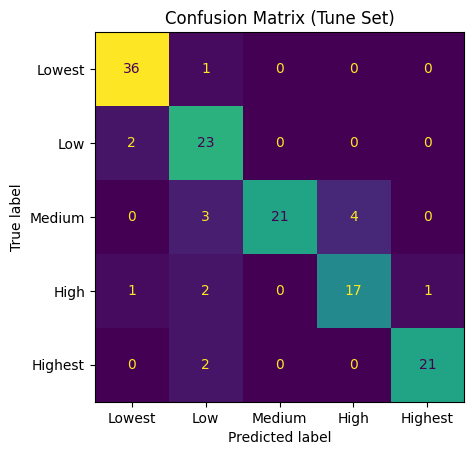

In [22]:
# New confusion matrix display
ConfusionMatrixDisplay.from_estimator(best, X_tune, y_tune, display_labels=['Lowest','Low','Medium','High','Highest'], colorbar=False)
plt.title('Confusion Matrix (Tune Set)')
plt.show()

Classification for the high class greatly improved with the accuracy significantly increasing. Including more parameters improves model performance.

In [23]:
y_pred_tune = best.predict(X_tune)
y_pred_test = best.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test, digits=4))

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9259    0.9615    0.9434        26
           1     0.8966    0.8667    0.8814        30
           2     0.8077    0.7778    0.7925        27
           3     0.7879    0.9286    0.8525        28
           4     1.0000    0.8261    0.9048        23

    accuracy                         0.8731       134
   macro avg     0.8836    0.8721    0.8749       134
weighted avg     0.8794    0.8731    0.8735       134



Our model has perfect precision for the highest class. The lowest precision is 78.8% for our high class, but this is an improvement over our lowest precision being 68.8% for our first decision tree.
The recall for our lowest class is 96.2%, an improvement over our first tree. Our middle class does not perform great, with 77.8%, but this is again an improvement.
Our f1 scores for ⅘ of our classes is over 85%, a great improvement from our first tree which produced most f1-scores around 80%.
Our overall accuracy improved by about 4%
The macro average and weighted average improved for every metric with this new model.
Overall, our tree's performance improved. Our errors are more concentrated in the middle classes, but this makes sense.

87.3% accuracy which is a significant improvement from our first model

In [24]:
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
varimp['importance'] = varimp['importance'].round(2)
print(varimp)

          importance
age             0.55
smoker          0.27
children        0.10
bmi             0.06
sex             0.01
region          0.00


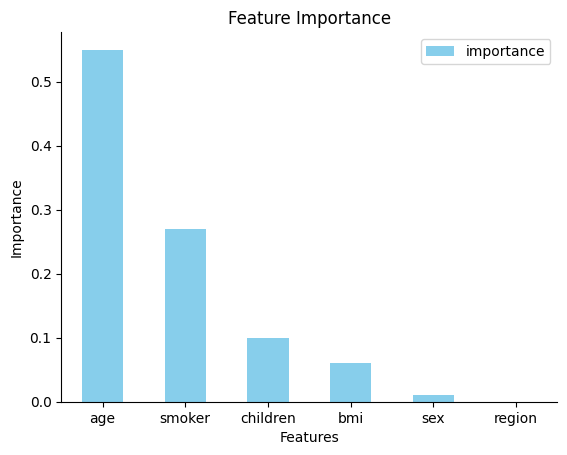

In [25]:
varimp.plot(kind='bar', color='skyblue')
plt.xlabel('Features')
plt.xticks(rotation=0, size=10)
plt.ylabel('Importance')
plt.title('Feature Importance')

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Age is still our most important variable, but by a less wide margin now. All of our variable seem to contribute to the model except region, which makes sense.

In [26]:
dot_data = export_graphviz(best, out_file=None,
               feature_names=X.columns, # feature names from dataset
               filled=True, 
               rounded=True, 
               class_names=['Lowest', 'Low', 'Medium', 'High', 'Highest']) # classification labels 
graph_2 = graphviz.Source(dot_data)
graph_2 = graphviz.Source(dot_data)
graph_2
graph_2.render("graph_2")

'graph_2.pdf'